## Report "Car optimization challenge"
#### author: "Evgeniya Vorontsova"
#### date: "February, 2021"

![Alt](bus.png "")

### Goal: minimize the energy consumption
### Find: 
#### * optimal shape of the vehicle;
#### * the optimal size of the wheels;
#### * the optimal combustion engine

In [13]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

#### We need to find datasets with dependency between the energy consumption (fuel) and the parameters of vehicles 


### Fuel Economy Data (US Department of Energy)
https://www.fueleconomy.gov/feg/download.shtml   43 000 cars

In [90]:
vehicles=pd.read_csv("vehicles.csv")
vehicles.info()

C:\Users\JaneN\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (70,71,72,73,74,76,79) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43295 entries, 0 to 43294
Data columns (total 83 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   barrels08        43295 non-null  float64
 1   barrelsA08       43295 non-null  float64
 2   charge120        43295 non-null  float64
 3   charge240        43295 non-null  float64
 4   city08           43295 non-null  int64  
 5   city08U          43295 non-null  float64
 6   cityA08          43295 non-null  int64  
 7   cityA08U         43295 non-null  float64
 8   cityCD           43295 non-null  float64
 9   cityE            43295 non-null  float64
 10  cityUF           43295 non-null  float64
 11  co2              43295 non-null  int64  
 12  co2A             43295 non-null  int64  
 13  co2TailpipeAGpm  43295 non-null  float64
 14  co2TailpipeGpm   43295 non-null  float64
 15  comb08           43295 non-null  int64  
 16  comb08U          43295 non-null  float64
 17  combA08     


##### Drop unnecessary columns

In [40]:
vehicles = vehicles[['barrels08', 'cylinders', 'fuelType', 'displ', 'drive', 'make', 'model', 'trany']]
vehicles = vehicles[vehicles['fuelType'] == 'Regular']
vehicles = vehicles[vehicles['cylinders'] != 'NA']
vehicles.dropna(subset=['drive', 'trany', 'cylinders'], inplace = True)

C:\Users\JaneN\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [4]:
vehicles.head()

,barrels08,cylinders,fuelType,displ,drive,make,model,trany
0,15.695714,4.0,Regular,2.0,Rear-Wheel Drive,Alfa Romeo,Spider Veloce 2000,Manual 5-spd
1,29.964545,12.0,Regular,4.9,Rear-Wheel Drive,Ferrari,Testarossa,Manual 5-spd
2,12.207778,4.0,Regular,2.2,Front-Wheel Drive,Dodge,Charger,Manual 5-spd
3,29.964545,8.0,Regular,5.2,Rear-Wheel Drive,Dodge,B150/B250 Wagon 2WD,Automatic 3-spd
5,14.982273,4.0,Regular,1.8,Front-Wheel Drive,Subaru,Loyale,Automatic 3-spd


* barrels08 - annual petroleum consumption in barrels
* cylinders - engine cylinders
* fuelType
* displ - engine displacement in liters
* drive - drive axle type 
* make - manufacturer (division)
* model - model name (carline)
* trany - transmission

#### Minimize barrels08

#### Find optimal cylinders, displ, drive, make, model, trany

In [5]:
vehicles.describe()

,barrels08,cylinders,displ
count,26310.000000,26310.000000,26310.00000
mean,17.185404,5.376245,3.12726
std,4.549273,1.512482,1.27073
min,5.586610,2.000000,1.00000
25%,13.733750,4.000000,2.00000
50%,16.480500,6.000000,2.80000
75%,19.388824,6.000000,4.00000
max,41.201250,12.000000,7.40000


In [41]:
vehicles['drive'].replace(to_replace="Rear-Wheel Drive", value=1, inplace = True)
vehicles['drive'].replace(to_replace="Front-Wheel Drive", value=2, inplace = True)
vehicles['drive'].replace(to_replace="4-Wheel or All-Wheel Drive", value=3, inplace = True)
vehicles['drive'].replace(to_replace="2-Wheel Drive", value=4, inplace = True)
vehicles['drive'].replace(to_replace="4-Wheel Drive", value=5, inplace = True)
vehicles['drive'].replace(to_replace="All-Wheel Drive", value=6, inplace = True)
vehicles['drive'].replace(to_replace="Part-time 4-Wheel Drive", value=7, inplace = True)

In [42]:
le1 = preprocessing.LabelEncoder()
le1.fit(vehicles['make'])
vehicles['make'] = le1.transform(vehicles['make'])

le2 = preprocessing.LabelEncoder()
le2.fit(vehicles['model'])
vehicles['model'] = le2.transform(vehicles['model'])

le3 = preprocessing.LabelEncoder()
le3.fit(vehicles['trany'])
vehicles['trany'] = le3.transform(vehicles['trany'])

print(le1.classes_, le2.classes_, le3.classes_)

['AM General' 'Acura' 'Alfa Romeo' 'American Motors Corporation'
 'Aston Martin' 'Audi' 'Aurora Cars Ltd' 'Autokraft Limited' 'BMW'
 'Bertone' 'Bill Dovell Motor Car Company' 'Bitter Gmbh and Co. Kg'
 'Buick' 'CCC Engineering' 'CX Automotive' 'Cadillac' 'Chevrolet'
 'Chrysler' 'Consulier Industries Inc' 'Dabryan Coach Builders Inc'
 'Dacia' 'Daewoo' 'Daihatsu' 'Dodge' 'E. P. Dutton, Inc.' 'Eagle'
 'Evans Automobiles' 'Federal Coach' 'Ferrari' 'Fiat' 'Ford' 'GMC'
 'General Motors' 'Genesis' 'Geo' 'Grumman Allied Industries' 'Honda'
 'Hummer' 'Hyundai' 'Import Foreign Auto Sales Inc'
 'Import Trade Services' 'Infiniti' 'Isuzu' 'J.K. Motors'
 'JBA Motorcars, Inc.' 'Jaguar' 'Jeep' 'Kia' 'Laforza Automobile Inc'
 'Lambda Control Systems' 'Land Rover' 'Lexus' 'Lincoln'
 'London Coach Co Inc' 'Lotus' 'Maserati' 'Mazda' 'Mcevoy Motors'
 'Mercedes-Benz' 'Mercury' 'Merkur' 'Mitsubishi' 'Mobility Ventures LLC'
 'Nissan' 'Oldsmobile' 'Panos' 'Panoz Auto-Development'
 'Panther Car Company Limited' 

### Modelling approach

#### Regression

In [15]:
from statsmodels.api import OLS
from statsmodels.api import add_constant

X = vehicles.drop(columns = ['barrels08', 'fuelType'])
X = np.asarray(X, dtype = 'float')
y = vehicles['barrels08'].values

# Divide the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# First model is Regression
X_train_c = add_constant(X_train)
ols = OLS(y_train, X_train_c)
model1 = ols.fit()
print(model1.summary())

X_test_c = add_constant(X_test)
y_pred = model1.predict(X_test_c)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     8322.
Date:                Sun, 31 Jan 2021   Prob (F-statistic):               0.00
Time:                        13:15:46   Log-Likelihood:                -48925.
No. Observations:               21048   AIC:                         9.786e+04
Df Residuals:                   21041   BIC:                         9.792e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5027      0.134     33.663      0.0

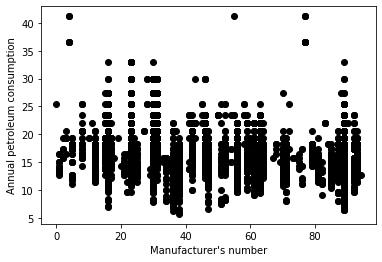

In [16]:
# scatter-plot data
plt.ylabel('Annual petroleum consumption')
plt.xlabel('Manufacturer\'s number')
ax = plt.plot(X_test[:, 3], y_test, 'o', color = 'black')

In [71]:
print(le1.inverse_transform([36]), le2.inverse_transform([548]))

['Honda'] ['Civic HB VX']


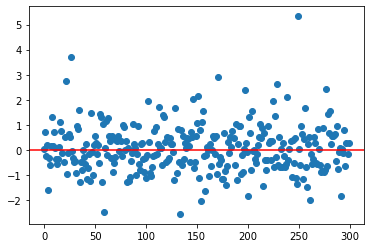

In [18]:
stdres = pd.DataFrame(model1.resid_pearson)
plt.plot(stdres.iloc[0:300], 'o', ls = 'None')
l = plt.axhline(y=0, color = 'r')

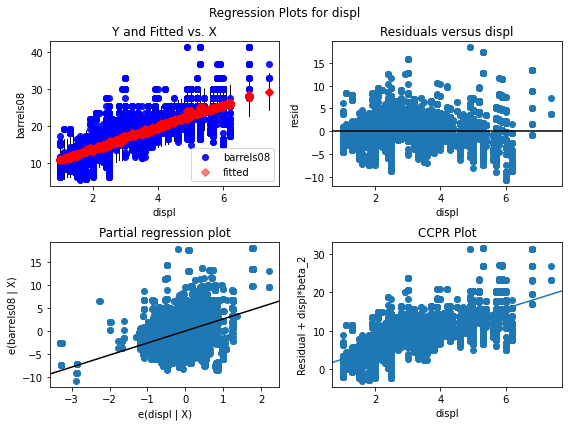

In [19]:
fig = plt.figure(figsize=(8, 6))
model_pandas = smf.ols('barrels08 ~ cylinders + displ + drive + make + model', data=vehicles).fit()
sm.graphics.plot_regress_exog(model_pandas, 'displ', fig=fig)
plt.show()

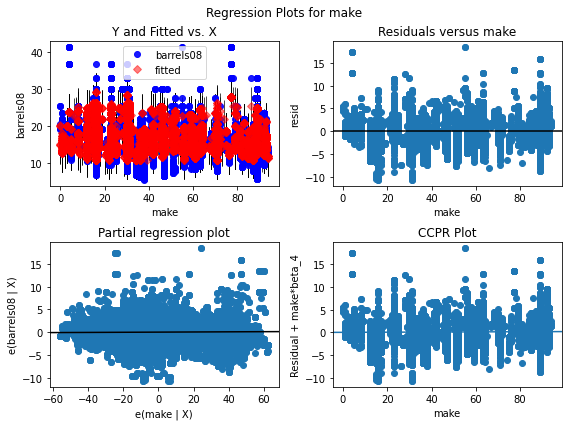

In [20]:
fig = plt.figure(figsize=(8, 6))
sm.graphics.plot_regress_exog(model_pandas, 'make', fig=fig)
plt.show()

In [21]:
model_pandas.params

Intercept    7.320217
cylinders    0.316814
displ        2.627662
drive       -0.074601
make         0.001641
model        0.000034
dtype: float64

In [89]:
new_data = pd.DataFrame({'cylinders': [4], 'displ': [1], 'drive': [5], 'make': [36], 'model': [548]})
f_new = model_pandas.get_prediction(exog=new_data) 
f_new.summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,10.919823,0.057725,10.806679,11.032967,5.951788,15.887858


In [96]:
new_data = pd.DataFrame({'cylinders': [2], 'displ': [1], 'drive': [5], 'make': [36], 'model': [548]})
f_new = model_pandas.get_prediction(exog=new_data) 
f_new.summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,10.286195,0.057459,10.173572,10.398818,5.318172,15.254218


##### Minimal annual petroleum consumption: 10.3 barrels 
     
##### Optimal shape and wheels: like Honda Civic HB VX. Note: when you optimize the size of wheels, consider their service life.

##### Some optimal constuction features: 2 cylinders, engine displacement in liters: 1, 4-Wheel drive type

### Performance analysis

In [92]:
from sklearn.metrics import mean_squared_error
rmse1 = mean_squared_error(y_pred, y_test, squared = False)
print(rmse1)

2.491984645634899


### Potential improvements

###### 1. Datasets for buses
###### 2. Other models (random forest, neural networks, ...)
###### 3. Data exploration
###### 4. Process optimization approach


## Thank you for your attention!

    

![Alt](cube.png "")